# DeepSeekMath-V2: Towards Self-Verifiable Mathematical Reasoning [1]

## Motiváció

A DeepSeek szerint a nagy nyelvi modellek érvelési képességének fontos tesztelési környezete a matematikai érvelés. Eddig módszerek, mint pl. megerősítéses tanulás használata a helyes eredmények jutalmazására [2] több alapvető korláttal rendelkeznek:

1. A helyes végválasz nem garantálja a helyes érvelést (akár szerencsés hibák esetén is el lehet jutni helyes válaszhoz).
2. Tételbizonyításra nem használhatóak, hiszen nem egy numerikus végeredményt várunk.
 
A szerzők állítják, hogy egy nagy nyelvi modell betanítható arra, hogy természetes nyelvi bizonyításokat ellenőrizzen, referencia megoldás nélkül. A verifikátor hűségét egy meta-verifikátor növeli, amely ellenőrzi, hogy a verifikátor általl jelzett hibák valóban fennállnak-e, és az indoklás megfelel-e a rublikának.

Egy megbízható verifikátor birtokában a bizonyítás-generátor modellt úgy tanítják, hogy ön-verifikációt végezzen: saját megoldását a verifikátoréval azonos rubrika szerint elemzi, és jutalmazzák, ha feltárja, majd javítja a problémákat.

## Bizonyítás-ellenőrzés

Az ellenőrző modell egy olyan LLM, amely egy adott feladathoz tartozó természetes nyelvű bizonyításhoz hibákat azonosít, majd összpontszámot ad egy rubrika szerint. A DeepSeek ezt a verifikátort RL-el tanítja, hogy formailag helyes és a rubrikához hű értékeléseket adjon.

### Rubrika

Az ellenőrzés háromszintű rubrika szerint történik (ld. Appendix A.2 a cikkben):

- 1: Teljesen korrekt bizonyítás, minden lépés tisztán indokolt
- 0.5: Nagyjából korrekt, de kisebb hiányosságok vagy apró hibák vannak.
- 0: Alapvetően hibás vagy kritikus hiányt tartalmaz, nem bizonyítja a kitűzött tételt.

A rubrika kifejezetten kimondja azt is, hogy külső hivatkozás nem pótolja a bizonyítást.

### Kezdeti adatok és címkézés

- Forrásuk válogattot, bizonyítást igénylő feladatok (AoPS versenyek, olimpiai és válogató feladatok, összesen 17503 db).
- Egy előzetes reasoning modell segítségével (DeepSeek-V3.2-Exp-Thinking) több körben finomította a bizonyításokat, hogy minél részletesebb legyen.
- Emberi pontozás segítségével a rubrika szerint egy kezdeti adatkészletet készítettek. Megjegyzés. Ennek részletesnek, és rubrika-hűnek kell lennie.

### RL-célfüggvény

A verifikátor kimenete két részletből áll: (1) hibaösszegzés és (2) végpontszám.

- Formátum-jutalom: megköveteli a helyes szövegformátumot, úgy, hogy ellenérzi, hogy a szövegben benne vannak-e kulcsmondatok, mint pl.  `Here is my evaluation of the solution`, illetve tartalmaz-e `\boxed{}` környezetben egy végpontszámot.
- Pontszám-jutalom: a generált pontszám közelsége a rubrika-címkéhez.

A tanítás GRPO [3] változattal történik.

Megjegyzés. Ha a verifikátor csak a pontszámra kap jutalmat, akkor tanítás közben helyes pontszámot is elérhet nem létező hibák felsorolásával. Ezért jött létre a meta-verifkáló modell, amely ellenőrzi a verifikátor elemzését.

## Meta-verifikátor

A verifikátor RL-célja eddig a pontszám-illesztés volt: ha egy hibás bizonyítást helyesen pontoz, jutalmat kap. Ez azonban nyitva hagyja a kiskaput, hogy hibákat hallucináljon, vagyis a modell úgy is felveheti a helyes pontszámot, hogy nem létező hibákat sorol, és gyenge indoklást ad.

### Kezdeti adatok és rubrika

- Az előző szekcióban leírt GRPO-val tanított verifikátor a kiindulási helyzet.
- Szakértők pontozzák a verifikátor elemzéseinek minőségét a meta-rubrika szerint (ismételten 0, 0.5, 1 halmaz elemein).
- A meta-verifikátor bemenetként megkapja a (probléma, bizonyítás, elemzés) hármast, és visszaad egy hiba-ellenőrzési összegzést + minőséégi pontszámot.

### RL-célfüggvény

Hasonló szerkezetű, mint a verifikátor tanítása:

- Formátum jutalomm
- Pontszám jutalom

A tanítás ismételten GRPO használatával történik.

### Meta-jutalom integrálása a verifikátorba

A tanított meta-verifikátor minőségi pontszámot ad a verifikátor elemzésére. Ez használva van a verifikátor jutalomfüggvényében, szorozva a másik két komponenssel.

Így a verifikátor csak akkor kap magas jutalmat, ha:

1. A formátum helyes.
2. A pontszám illeszkedik.
3. A talált hibák tényleg léteznek és indokoltak.

### Minőségi javulás

A meta-verifikációval újratanított verifikátor esetén a meta-értékelő átlagpontja (azaz, a verifikátor elemzésének minősége) $0.85$-ről $0.96$-ra javult a validációs adathalmazon.


## Generátor ön-verifikációval

Cél: a bizonyítás-generátor ne csak megoldást adjon, hanem ugyanazon rubrika szerint értékelje a saját megoldását, majd a feltárt hibákat megpróbálja kijavítani. A DeepSeekMath-V2 ezt explicit jutalommal tanítja: a végső jutalom a bizonyítás minősége és az ön-ellenőrzés minősége kombinációja, kötelező formátum-ellenőrzéssel.

### Tanítás

A generátor egy lépésben két kimenetet ad: (1) bizonyítás, és (2) ön-ellenőrzés, ahol az utóbbi a verifikátorral azonos rubrika szerint elemzi a saját bizonyítást. A verifikátor ezután két pontszámot állít elő:

- A bizonyítás rubrika pontja.
- Az ön-ellenőrzés minősége, a meta-verifikátorral ellenőrizve.

Ezek pedig súlyozva vannak:

$$
R \;=\; R_{\text{format}}(\Pi,A)\;\cdot\;\big(\,\alpha\cdot R_{\Pi} \;+\; \beta\cdot R_{A}\,\big),
$$

ahol

$$
R_{A} \;=\; R_{\text{score}}\big(\hat s, s\big)\cdot R_{\text{meta}}(A)\,,
$$

$\hat s$ a generátor ön‑pontszáma, $s$ a verifikátor által adott pontszám; $\alpha=0.76$, $\beta=0.24$ a cikkben megadott súlyok. A formátumra kapott jutalom kötelezővé teszi a részletes értékelést és a `\boxed{}` környezetben található végpontszámot, ezért a jutalom csak szabályos, kinyerhető kimenet esetén aktiválódik.

### Miért kell ön-ellenőrzés?

Empirikusan megfigyelték, hogy ha a generátort megkérik "egylépésben" megoldás + saját értékelés megadására, akkor hajlamos tévesen korrektnek minősíteni a bizonyítást, miközben egy külső verifikátor könnyen talál hibákat. Az ön-ellenőrzés jutalommal viszont a generátor ugyanúgy értékel, mint a dedikált verifikátor.

## Iteratív finomítás

Kihívó feladatoknál gyakori, hogy egy 128 ezres kontextusbon belül nem fér el minden részlet és javítás. Ilyenkor a folyamat többször fut:

1. generálás + ön-ellenőrzés,
2. a saját elemzés alapján újrapróbálkozás,
3. megállás, ha az ön-ellenőrzés pontszáma eléri az 1-et.

Az eredmények azt mutatják, hogy a Pass@1 eredmény folyamatosan nő az engedett iterációk számával, és a Best@N (ön-ellenőrzés alapján kiválasztva) lényegesen magasabb verifikációs pontszámot ér el, ami azt jelzi, hogy a generátor megbízhatóan meg tudja különböztetni a jó és a hibás bizonyításokat.

In [ ]:
# Pszeudo-kód a generátor ön-ellenőrző tanításáról
for (problem) in batch:
    proof, self_analysis, self_score = generator(problem)
    verifier_score = verifer(problem, proof)
    meta_score - meta_verifier(problem, proof, self_analysis)

    self_reward = score_reward(self_score, verifier_score)
    reward = format_reward(problem, analysis) * (alpha * verifier_score + beta * self_reward)

    grpo_update(policy=generator, reward=reward)

## Tesztidős skálázott verifikáció

A legnehezebb feladatoknál nem elég egyetlen bizonyítás és egyetlen ellenőrzés, sokszoros verifikálás és finomítás szükséges. A DeepSeekMath-V2 egy teljeseen automatizált címkézési folyamatot vezetett be, amely a későbbi iterációkban teljes mértékben kiváltotta az emberi annotációt.

- Több, egymástól független verifikátor elemzés esetén nő annak a valószínűsége, hogy legalább az egyik elemzés valódi hibát talál egy valódi hibát.
- A meta-verifikáció egyszerűsíti az ellenőrzést: ahelyett, hogy nulláról keresnénk a hibát, csak azt kell megállapítani, hogy a verifikátor által jelzett hiba valós-e és indokolt-e, ami az LLM-ek számára hatékonyabb feladat.

### Automatikus címkézés

1. Minden (probléma, bizonyítás) párhoz valamennyi, $B$ független verifikátor-elemzést generálnak.
2. Minden verifikátor elemzésre, amely hibát állít, lefuttatnak $A$ meta-verifikációt. Akkor tekintik érvényesnek az elemzést, ha a meta-értékelések többsége megerősíti a hibt és annak indoklását.
3. Egy bizonyításhoz a legalacsonyabb pontszámot adó, ervényesnek minősített verifikátor-elemzések közül kiválasztanak legalább $T$ darabot, ha van legalább $T$, akkor azzal a legalacsonyabb pontszámmal címkézik a bizonyítást, ha sehol nem azonosítható valós hiba, akkor 1-re címkéznek, minden más eset eldobás vagy emberi címkézés.

> A minőségellenőrzések azt mutatták, hogy a címkék jól egyeznek a szakértői itéletekkel.

A módszer arany-szintű eredményeket hozott IMO feladatokon.

In [1]:
# Automatikus címkézéshez pszeudokód
def auto_label(proof, problem, B=64, A=5, T=2):
    analyses = [verifier(problem, proof) for _ in range(B)]
    
    valid = []
    for a in analyses:
        if a.score in (0, 0.5):
            metas = [meta_verifier(problem, proof, a) for _ in range(A)]
            if majority_confirms(metas):
                valid.append(a)

    lowest = min([a.score for a in valid], default=1)
    if lowest < 1 and sum(1 for a in valid if a.score == lowest) >= T:
        return lowest
    elif not valid:
        return 1
    else:
        return None

## Eredmények

### Belsős CNML-szintű problémák (91) feladat

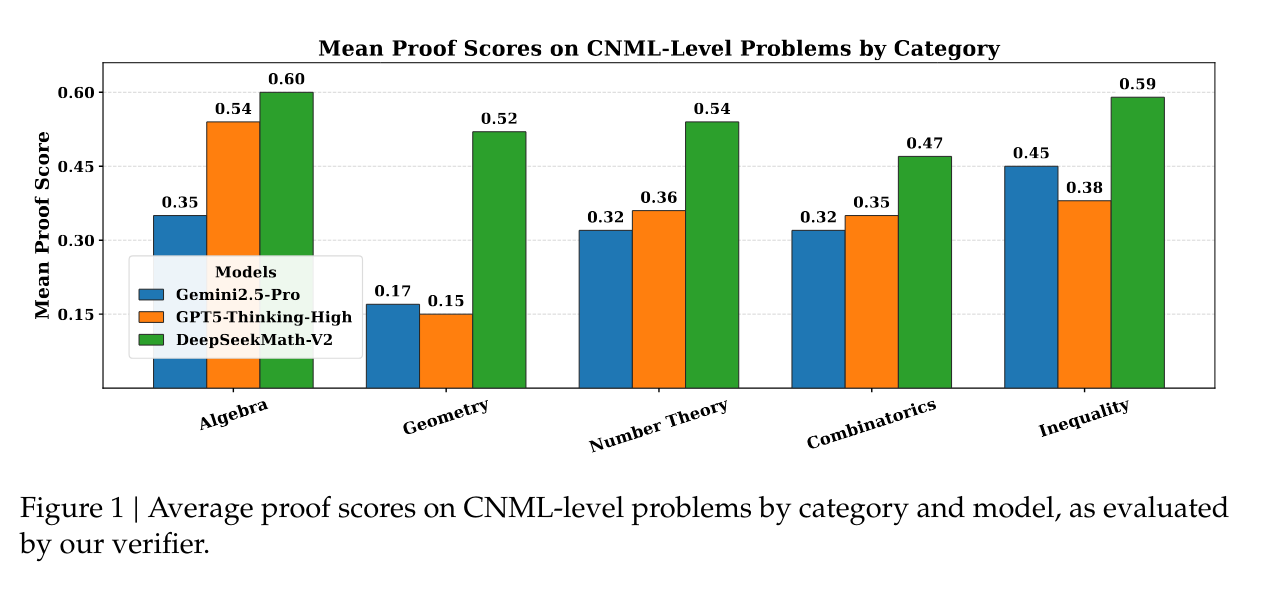

- A modell területek szerint (algebra, geometria, számelmélet, kombinatorika, egyenlőtlenségek) átlagolt bizonyítás-pontszáma minden területen felülmálja az összes eddigi modellt.
- A pontozás többszörös verifikációval történik.

### Szekvenciális finomítás ön-ellenőrzéssel

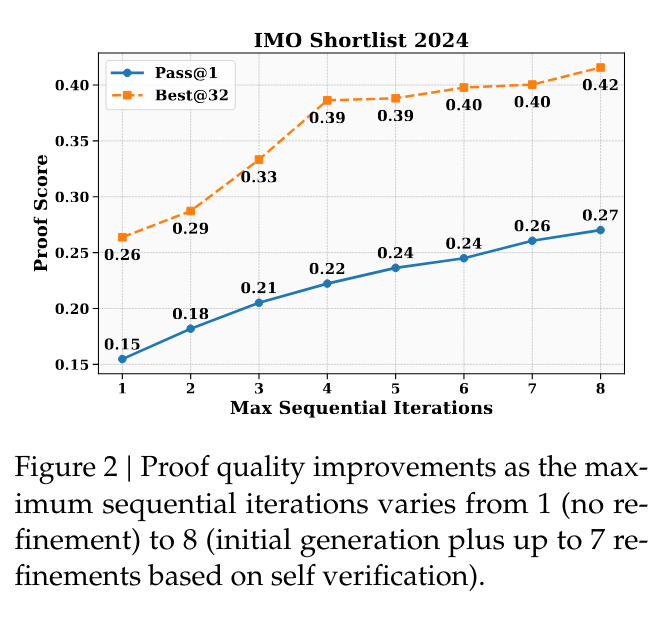

- A Pass@1 szignifikánsan javul.
- A Best@32 lényegesen magasabb.

### IMO-ProofBench

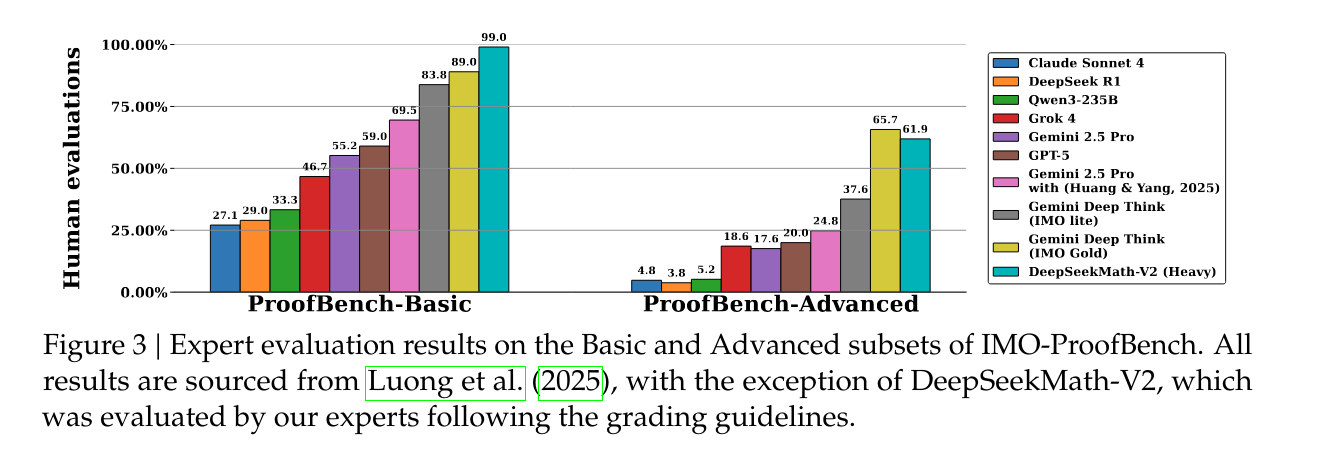

### Versenyfeladatok

- IMO 2025: 6 feladatból 5 teljes megolddás, arany-szintű teljesítmény.
- CMO 2024: 4 feladat teljesen megoldva + egy részpont egy további feladatra.
- Putnam 2024: 11/12 feladat teljes megoldás + 118/120 pont.

## Hivatkozások

1. Zhihong Shao, Yuxiang Luo, Chengda Lu, Z.Z. Ren, Jiewen Hu, Tian Ye, Zhibin Gou, Shirong Ma, Xiaokang Zhang. "DeepSeekMath-V2: Towards Self-Verifiable Mathematical Reasoning", 2025. https://doi.org/10.48550/arXiv.2511.22570
2. DeepSeek-AI, Daya Guo, Dejian Yang, Haowei Zhang, Junxiao Song, Peiyi Wang, Qihao Zhu, Runxin Xu, Ruoyu Zhang, Shirong Ma, Xiao Bi, Xiaokang Zhang, Xingkai Yu, Yu Wu, Z.F. Wu, Zhibin Gou, Zhihong Shao, Zhuoshu Li, Ziyi Gao, Aixin Liu, Bing Xue, Bingxuan Wang, Bochao Wu, Bei Feng, Chengda Lu, Chenggang Zhao, Chengqi Deng, Chenyu Zhang, Chong Ruan, Damai Dai, Deli Chen, Dongjie Ji, Erhang Li, Fangyun Lin, Fucong Dai, Fuli Luo, Guangbo Hao, Guanting Chen, Guowei Li, H. Zhang, Han Bao, Hanwei Xu, Haocheng Wang, Honghui Ding, Huajian Xin, Huazuo Gao, Hui Qu, Hui Li, Jianzhong Guo, Jiashi Li, Jiawei Wang, Jingchang Chen, Jingyang Yuan, Junjie Qiu, Junlong Li, J.L. Cai, Jiaqi Ni, Jian Liang, Jin Chen, Kai Dong, Kai Hu, Kaige Gao, Kang Guan, Kexin Huang, Kuai Yu, Lean Wang, Lecong Zhang, Liang Zhao, Litong Wang, Liyue Zhang, Lei Xu, Leyi Xia, Mingchuan Zhang, Minghua Zhang, Minghui Tang, Meng Li, Miaojun Wang, Mingming Li, Ning Tian, Panpan Huang, Peng Zhang, Qiancheng Wang, Qinyu Chen, Qiushi Du, Ruiqi Ge, Ruisong Zhang, Ruizhe Pan, Runji Wang, R.J. Chen, R.L. Jin, Ruyi Chen, Shanghao Lu, Shangyan Zhou, Shanhuang Chen, Shengfeng Ye, Shiyu Wang, Shuiping Yu, Shunfeng Zhou, Shuting Pan, S.S. Li et al. "DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning", 2025. https://doi.org/10.1038/s41586-025-09422
3. Zhihong Shao, Peiyi Wang, Qihao Zhu, Runxin Xu, Junxiao Song, Xiao Bi, Haowei Zhang, Mingchuan Zhang, Y.K. Li, Y. Wu, Daya Guo. "DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models", 2024. https://doi.org/10.48550/arXiv.2402.03300